## Notebook for preprocessing of raw EEG data and exporting epochs

In [7]:
# import libraries
!pip install mne

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import mne
from mne.preprocessing import ICA
import pandas as pd
from scipy.stats import zscore

In [ ]:

# defining the events
event_id_monday_recording = {
    'Word/wPos': 11, # positive word
    'Wait/wPos': 31, # waiting time after positive word 
    'Image/wPos': 21, # positive image (always following pos word) 
    'Word/wNeg': 12, # negative word
    'Wait/wNeg': 32, # waiting time after negative word 
    'Image/wNeg': 22, # negative image (always following neg word) 
    'Word/wNeu': 13, # neutral word
    'Wait/wNeu/iPos': 51, # wait time after neu w (before pos i) 
    'Image/wNeu/iPos': 41, # positive image (after neu word) 
    'Wait/wNeu/iNeg': 52, # wait time after neu w (before neg i) 
    'Image/wNeu/iNeg': 42, # negative image (after neu word) 
    'Correct/wPos': 201, # correct response ('b') to pos w + image 
    'Correct/wNeg': 102, # correct response ('y') to neg w + image 
    'Correct/wNeu/iPos': 111, # cor resp ('b') to neu w + pos image 
    'Correct/wNeu/iNeg': 112, # cor resp ('y') to neu w + neg image 
    'Incorrect/wPos': 202, # incor resp ('y') to pos w + image 
    'Incorrect/wNeg': 101, # incor resp ('b') to neg w + image 
    'Incorrect/wNeu/iPos': 212, # incor resp ('y') to neu w + pos i 
    'Incorrect/Neu/iNeg': 211 # incor resp ('b') to neu w + neg i
}

event_id = {
    'Word/wPos': 11, # positive word
    'Wait/wPos': 31, # waiting time after positive word 
    'Image/wPos': 21, # positive image (always following pos word) 
    'Word/wNeg': 12, # negative word
    'Wait/wNeg': 32, # waiting time after negative word 
    'Image/wNeg': 22, # negative image (always following neg word) 
    'Word/wNeu': 13, # neutral word
    'Wait/wNeu/iPos': 51, # wait time after neu w (before pos i) 
    'Image/wNeu/iPos': 41, # positive image (after neu word) 
    'Wait/wNeu/iNeg': 52, # wait time after neu w (before neg i) 
    'Image/wNeu/iNeg': 42, # negative image (after neu word) 
    'Correct/wPos': 101, # correct response ('b') to pos w + image 
    'Correct/wNeg': 102, # correct response ('y') to neg w + image 
    'Correct/wNeu/iPos': 111, # cor resp ('b') to neu w + pos image 
    'Correct/wNeu/iNeg': 112, # cor resp ('y') to neu w + neg image 
    'Incorrect/wPos': 202, # incor resp ('y') to pos w + image 
    'Incorrect/wNeg': 201, # incor resp ('b') to neg w + image 
    'Incorrect/wNeu/iPos': 212, # incor resp ('y') to neu w + pos i 
    'Incorrect/Neu/iNeg': 211 # incor resp ('b') to neu w + neg i
}

In [2]:
def run_ica(raw, l_freq_fit=1., l_freq_apply=0.1, h_freq=40.,
            n_components=0.95, max_iter=800, random_state=7):

    raw.filter(l_freq_apply, h_freq, verbose=False)

    # 1 Hz copy just for ICA
    raw_fit = raw.copy().filter(l_freq_fit, h_freq, verbose=False)

    ica = ICA(n_components=n_components, max_iter=max_iter, random_state=random_state)
    ica.fit(raw_fit)

    eog_inds, _ = ica.find_bads_eog(raw_fit)
    ica.exclude = eog_inds
    ica.apply(raw)                 

    return raw, ica


In [3]:
def plot_and_save_raw_separately(raw_orig, raw_filtered, fig_path, groupname, start=200, duration=50):
    # Plot and save raw (unfiltered)
    fig_raw = raw_orig.plot(n_channels=32, show=False, title="Raw (Unfiltered) EEG")
    fig_raw.savefig(fig_path / f"{groupname}_raw.png")
    plt.close(fig_raw)

    # Plot and save ICA-filtered
    fig_filtered = raw_filtered.plot(n_channels=32, show=False, title="ICA Filtered EEG")
    fig_filtered.savefig(fig_path / f"{groupname}_ica_filtered.png")
    plt.close(fig_filtered)


In [ ]:
def preprocess_EEG_data(raw, bad_channels:list[str], event_id, groupname, fig_path, tmin = -0.1, tmax = 0.7, baseline = (None, 0), l_freq = 1.0, h_freq = 40.0, reject = {"eeg": 150e-6}):
    
    raw.info["bads"] = bad_channels

    # setting EOG channels correctly - different names for the channels on the two different acquistion computers
    try:
        raw.set_channel_types({"HEOG": "eog", "VEOG": "eog"})
    
    except(ValueError):
        raw.set_channel_types({"EOG1": "eog", "EOG2": "eog"})

    raw.set_montage("standard_1020")

    # dropping the remaining bad channels after interpolation
    raw.drop_channels(raw.info["bads"])

    raw.filter(l_freq, h_freq, verbose=False)

    # setting the reference
    raw.set_eeg_reference("average", projection=False, verbose = False)

    raw_original = raw.copy()

    raw, ica = run_ica(raw, n_components=0.95, max_iter=800, random_state=7)

    # Plotting raw and ICA-filtered signals for comparison
    plot_and_save_raw_separately(raw_original, raw, fig_path, groupname)

    # creating the events
    events, _ = mne.events_from_annotations(raw, verbose=False)

    # remove events from event id that are not in the data (to avoid errors when creating the epochs)
    event_id_tmp = {key: value for key, value in event_id.items() if value in events[:, 2]}

    # creating the epochs
    epochs_tmp = mne.Epochs(
        raw, 
        events, 
        event_id=event_id_tmp,
        tmin=tmin, 
        tmax=tmax, 
        baseline=baseline, 
        preload=True, 
        reject=reject,
        verbose = False
    )

    # downsample the epochs
    epochs_tmp = epochs_tmp.resample(250)

    return epochs_tmp

In [17]:
# load in the data
data_path = Path("FaceWord_EEG") 

# loading in the file with the bad channels identified by each group
session_info_path = data_path / "session_info.txt"

# load in session information (bad channels, etc.) txt file with dictionary
with open(session_info_path, "r") as f:
    session_info = eval(f.read())

print(session_info)

# creating a figures folder for saving plots from drop log
fig_path = Path("figures")

if not fig_path.exists():
    fig_path.mkdir(parents=True)

{'group0-fw2': {'bad_channels': ['Fp1', 'Fp2', 'F7', 'F8', 'F3'], 'tmin': None, 'tmax': None}, 'group1_fw': {'bad_channels': ['FC1'], 'tmin': None, 'tmax': None}, 'group2_fw': {'bad_channels': ['Fp1', 'Fp2'], 'tmin': None, 'tmax': None}, 'group3_fw': {'bad_channels': ['Fz', 'O2', 'CP5', 'Fp1', 'Fp2', 'T8'], 'tmin': None, 'tmax': None}, 'group4_fw': {'bad_channels': ['Fp1', 'Fp2', 'TP9', 'TP10'], 'tmin': None, 'tmax': None}, 'group5_fw': {'bad_channels': [], 'tmin': None, 'tmax': None}, 'group6_fw': {'bad_channels': [], 'tmin': 600, 'tmax': 1410}, 'group9_fw': {'bad_channels': ['Fp1', 'Fp2'], 'tmin': None, 'tmax': None}, 'group10_fw': {'bad_channels': [], 'tmin': None, 'tmax': None}, 'group11_fw': {'bad_channels': ['Fp1', 'Fp2', 'TP10'], 'tmin': None, 'tmax': None}, 'group15_fw': {'bad_channels': ['Fp1', 'Fp2', 'TP9', 'P7'], 'tmin': None, 'tmax': None}, 'group18_fw': {'bad_channels': ['Fp1', 'Fp2', 'T8'], 'tmin': None, 'tmax': None}, 'group19_fw': {'bad_channels': ['Fp1', 'Fp2'], 'tmin'

Preprocessing data from group0-fw2
Bad channels: ['Fp1', 'Fp2', 'F7', 'F8', 'F3']
Extracting parameters from FaceWord_EEG/group0-fw2.vhdr...
Setting channel info structure...
Reading 0 ... 1277059  =      0.000 ...  1277.059 secs...
Fitting ICA to data using 25 channels (please be patient, this may take a while)
Selecting by explained variance: 11 components
Fitting ICA took 16.3s.
Using EOG channels: EOG1, EOG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR fil

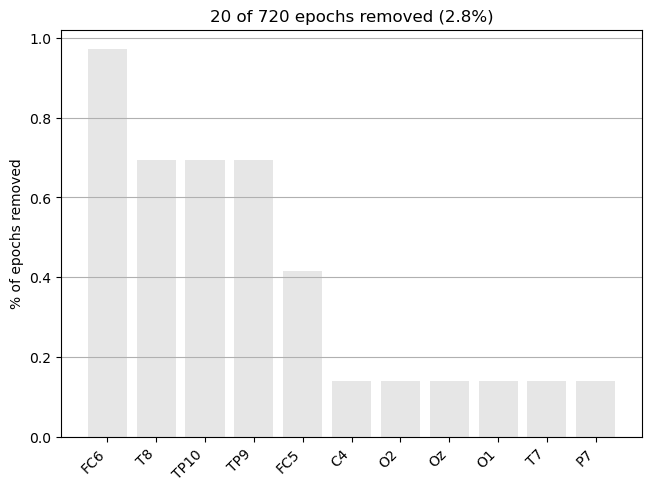

Preprocessing data from group1_fw
Bad channels: ['FC1']
Extracting parameters from FaceWord_EEG/group1_fw.vhdr...
Setting channel info structure...
Reading 0 ... 1287259  =      0.000 ...  1287.259 secs...
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Selecting by explained variance: 17 components
Fitting ICA took 16.4s.
Using EOG channels: HEOG, VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 s

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.4s


Applying ICA to Raw instance
    Transforming to ICA space (17 components)
    Zeroing out 1 ICA component
    Projecting back using 29 PCA components


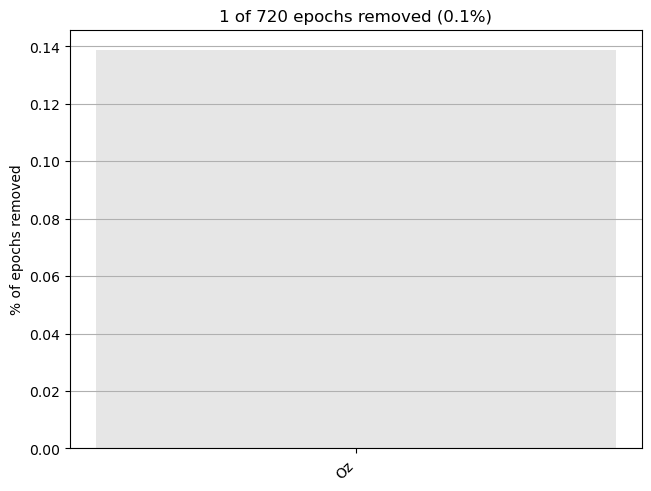

Preprocessing data from group2_fw
Bad channels: ['Fp1', 'Fp2']
Extracting parameters from FaceWord_EEG/group2_fw.vhdr...
Setting channel info structure...
Reading 0 ... 1260899  =      0.000 ...  1260.899 secs...
Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components
Fitting ICA took 20.4s.
Using EOG channels: EOG1, EOG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-----

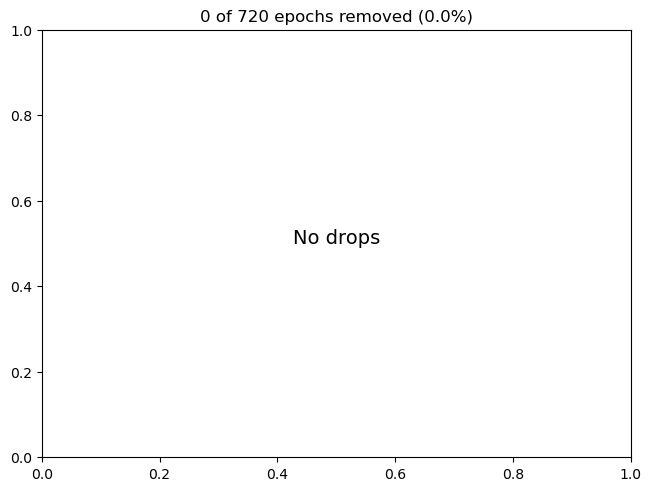

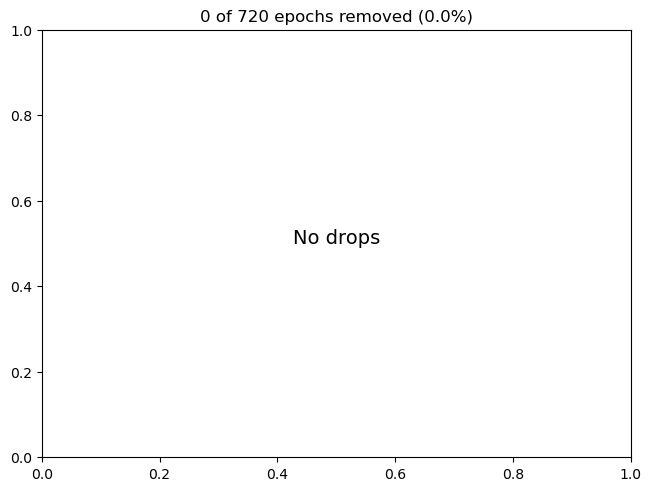

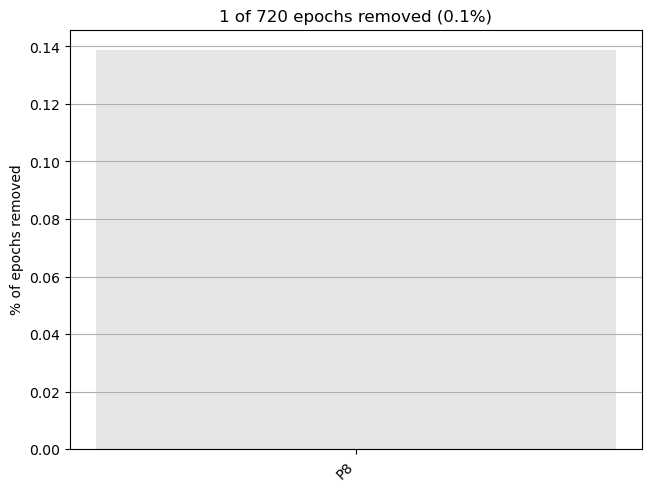

Preprocessing data from group5_fw
Bad channels: []
Extracting parameters from FaceWord_EEG/group5_fw.vhdr...
Setting channel info structure...
Reading 0 ... 1330019  =      0.000 ...  1330.019 secs...
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components
Fitting ICA took 11.7s.
Using EOG channels: EOG1, EOG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-----------------

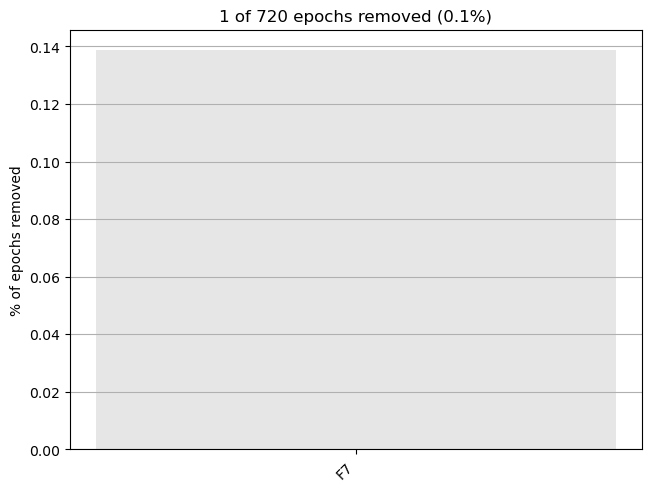

Preprocessing data from group6_fw
Bad channels: []
Extracting parameters from FaceWord_EEG/group6_fw.vhdr...
Setting channel info structure...
Reading 0 ... 1447119  =      0.000 ...  1447.119 secs...
Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by explained variance: 13 components
Fitting ICA took 9.9s.
Using EOG channels: EOG1, EOG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
------------------

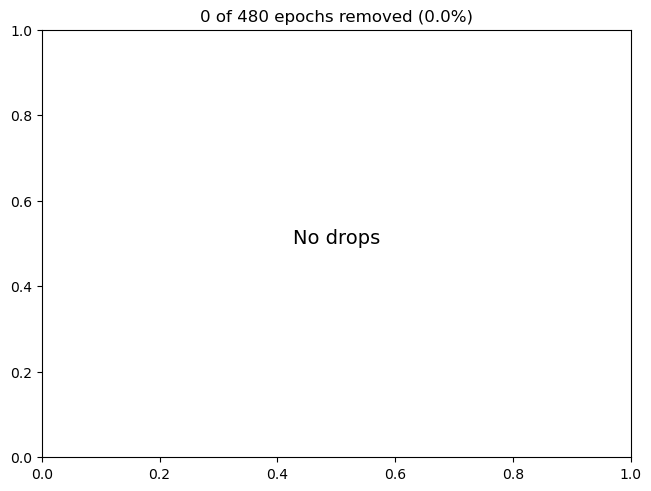

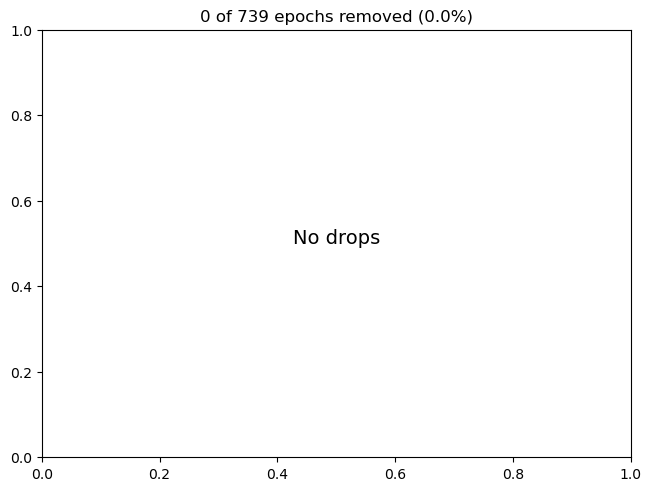

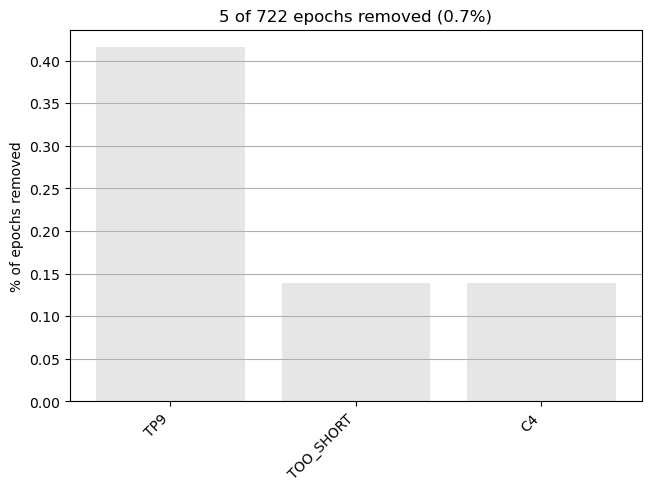

Preprocessing data from group11_fw
Bad channels: ['Fp1', 'Fp2', 'TP10']
Extracting parameters from FaceWord_EEG/group11_fw.vhdr...
Setting channel info structure...
Reading 0 ... 1335939  =      0.000 ...  1335.939 secs...
Fitting ICA to data using 27 channels (please be patient, this may take a while)
Selecting by explained variance: 14 components
Fitting ICA took 7.4s.
Using EOG channels: HEOG, VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter paramet

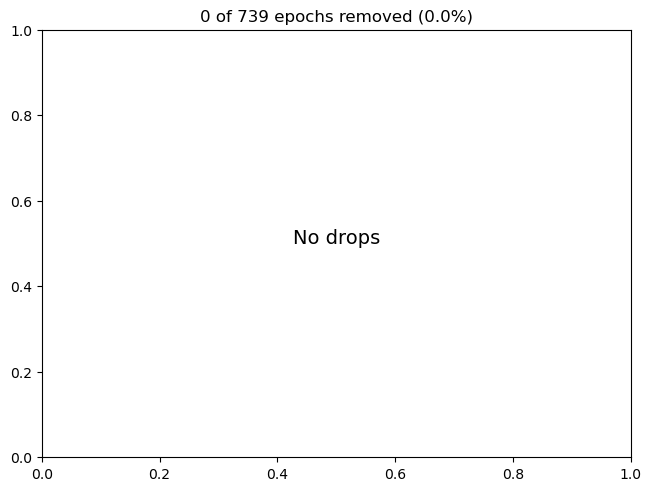

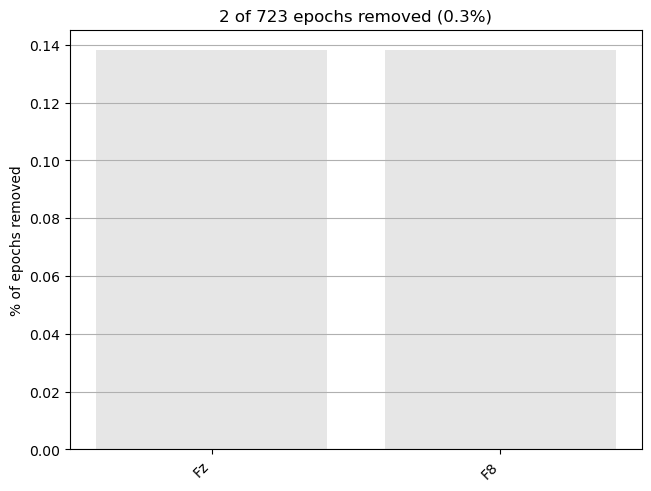

Preprocessing data from group18_fw
Bad channels: ['Fp1', 'Fp2', 'T8']
Extracting parameters from FaceWord_EEG/group18_fw.vhdr...
Setting channel info structure...
Reading 0 ... 1270739  =      0.000 ...  1270.739 secs...
Fitting ICA to data using 27 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components
Fitting ICA took 8.3s.
Using EOG channels: HEOG, VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameter

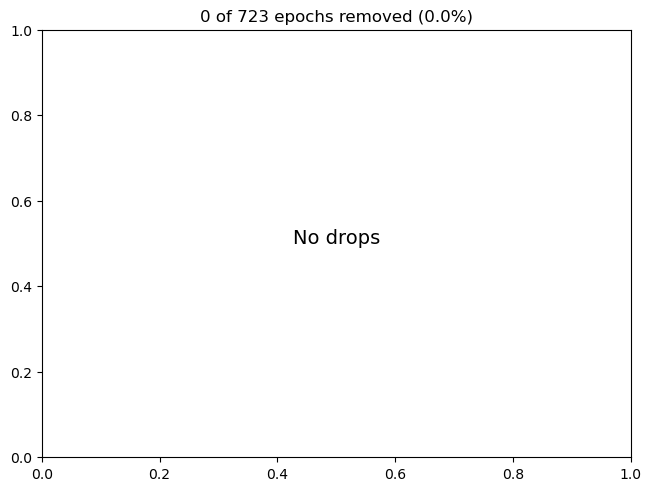

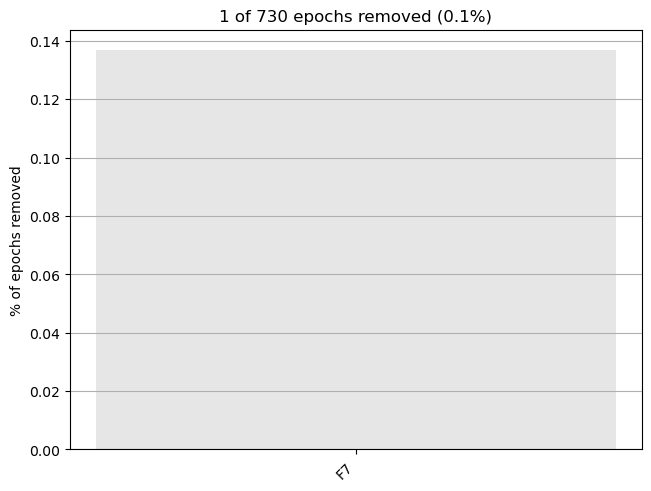

Preprocessing data from group20_fw
Bad channels: ['T7', 'T8']
Extracting parameters from FaceWord_EEG/group20_fw.vhdr...
Setting channel info structure...
Reading 0 ... 1260419  =      0.000 ...  1260.419 secs...
Fitting ICA to data using 28 channels (please be patient, this may take a while)
Selecting by explained variance: 12 components
Fitting ICA took 14.4s.
Using EOG channels: HEOG, VEOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
-----

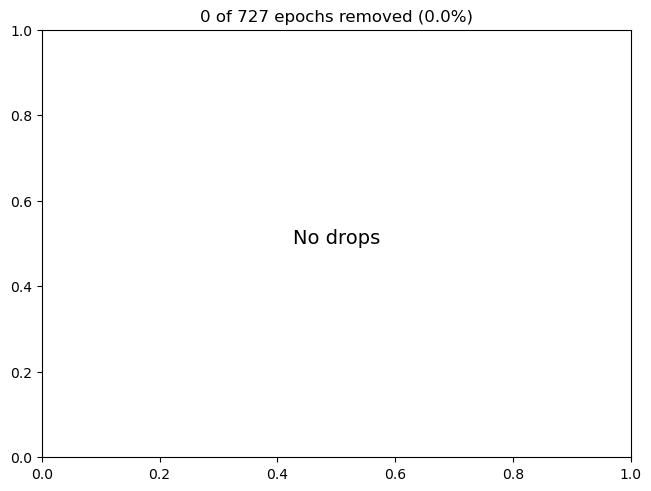

In [18]:
# Looping over the subjects and preprocessing
all_epochs = []

monday_recording = ["group0-fw2", "group1_fw", "group2_fw"]

for groupname, info in session_info.items():
    print(f"Preprocessing data from {groupname}")
    print(f"Bad channels: {info["bad_channels"]}")

    raw = mne.io.read_raw_brainvision(data_path / f"{groupname}.vhdr", preload=True)

    # check if the raw needs to be cropped
    if info["tmin"] != None or info["tmax"] != None: 
        raw.crop(info["tmin"], info["tmax"])
    
    if groupname in monday_recording:
        event_ids = event_id_monday_recording
    else:
        event_ids = event_ids

    preprocessed_epochs = preprocess_EEG_data(
        raw, 
        bad_channels=info["bad_channels"],
        event_id = event_ids,
        groupname=groupname,
        fig_path=fig_path
        )

    drop_log_fig = preprocessed_epochs.plot_drop_log()
    drop_log_fig.savefig(fig_path / f"{groupname}.png")

    all_epochs.append(preprocessed_epochs)

In [ ]:
#export epochs
import os

outpath = Path("epochs/final") 
outpath.mkdir(parents=True, exist_ok=True)     

for groupname, epochs in zip(session_info.keys(), all_epochs):
    fname = outpath / f"{groupname}-epo.fif"   # unique per participant
    epochs.save(fname, overwrite=True)         # set overwrite so reruns succeed